### [데이터 시각화]
- 데이터 셋 : iris.csv
- 해결 문제 : 품종별 시각화에 적합한 특성/속성/컬럼 선정
- 출력 결과 : 선정된 특성을 기반으로 품종 분류한 것 시각화

In [ ]:
## 모듈 로딩 및 데이터 셋 준비
import pandas as pd                 ## 데이터 분석용
import matplotlib.pyplot as plt     ## 데이터 시각화용
import koreanize_matplotlib         ## 한글 오류 잡기

## 데이터 준비
Data_File = '../Data/iris.csv'

## csv => DF
irisDF = pd.read_csv(Data_File)



In [12]:
## =======================================================
## [2-1] 기본 데이터 확인 : head(), info(), describe()
## -> 컬럼별 결측치 여부
## -> 컬럼별 실제데이터와 요약정보 데이터 타입 일치여부
## -> 컬럼별 데이터 분포 : 수치형/ 범주형
## =======================================================
## 실제 데이터 출력
display(irisDF.head(3))

## DF의 요약 정보
irisDF.info()

## 컬럼별 통계치/분포 확인 출력
display(irisDF.describe(include='all'))




,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal.length  150 non-null    float64
 1   sepal.width   150 non-null    float64
 2   petal.length  150 non-null    float64
 3   petal.width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


,sepal.length,sepal.width,petal.length,petal.width,variety
count,150.000000,150.000000,150.000000,150.000000,150
unique,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,Setosa
freq,NaN,NaN,NaN,NaN,50
mean,5.843333,3.057333,3.758000,1.199333,NaN
std,0.828066,0.435866,1.765298,0.762238,NaN
min,4.300000,2.000000,1.000000,0.100000,NaN
25%,5.100000,2.800000,1.600000,0.300000,NaN
50%,5.800000,3.000000,4.350000,1.300000,NaN
75%,6.400000,3.300000,5.100000,1.800000,NaN


In [ ]:
## =======================================================
## [2-2] 컬럼별 세부 체크 : isna() -> 드러나는 결측치 없음 
## -> 컬럼별 고유값 검사 : 이상치 체크 : 
##      uniques()       : 고유값 종류 
##      nunique()       : 고유값 갯수
##      value_counts()  : 값/고유값별로 데이터 수 
## =======================================================
for col in irisDF.columns :
    with open('./iris_unique.txt', mode='a', encoding='utf-8') as F:
    # with open(f'./{col}_iris_unique.txt', mode='w', encoding='utf-8') as F:  
        print(f'[{col}] ------------- {irisDF[col].nunique()}개 / {irisDF[col].dtype}', file=F)
        print(irisDF[col].unique(), file=F)
        print(f'-> 고유값 별 데이터 수 \n{irisDF[col].value_counts()}', file=F)
    print()

In [26]:
## =========================================================================
## [2-3] 컬럼별 세부 체크 : duplicarted() => 행/레코드 일치 중복값 체크
##       -> 행 별 중복값 가능한가 여부 결정 후 진행
## =========================================================================
print('중복행/샘플 수 :', irisDF.duplicated().sum())
irisDF[irisDF.duplicated()]

## => 동일한 객체 존재 가능함 ==> 유지!!

중복행/샘플 수 : 1


,sepal.length,sepal.width,petal.length,petal.width,variety
142,5.8,2.7,5.1,1.9,Virginica


In [29]:
## =========================================================================
## [2-4] 분류 문제로 타겟 컬럼의 균형 데이터 여부 체크
##          -> 품종별 데이터 개수 체크 : value_counts()
## =========================================================================
varietySR = irisDF.variety.value_counts()
display(varietySR)
print('품종별 데이터 수 :', varietySR.to_dict())

## => 균형 데이터


variety
Setosa        50
Versicolor    50
Virginica     50
Name: count, dtype: int64

품종별 데이터 수 : {'Setosa': 50, 'Versicolor': 50, 'Virginica': 50}


In [ ]:
## ----------------------------------------------------------------
## [2-5] 컬럼별 이상치 데이터 검사 진행 => IQR 사용
## ----------------------------------------------------------------

## ----------------------------------------------------------------
## 함수기능 : IQR기반 이상치 여부 검사 후 결과 반환
## 함수이름 : iqr_outlier_mask
## 매개변수 : sr                <-- series 인스턴스
##           k=1.5            <-- 임계값
## 결과반환 : 이상치 True, 정상 False 반환된 sr반환
## ----------------------------------------------------------------
def iqr_outlier_mask(sr,k=1.5):
    # 오름차순 정렬 후 중앙값, 중앙값 왼쪽부분 중앙값, 오른쪽 부분 중앙값 추출
    q1, q3 = sr.quantile([0.25, 0.75])
    iqr    = q3 - q1
    lower, upper = q1 - k * iqr , q3 + k * iqr
    return (sr<lower) | (sr > upper)



## ----------------------------------------------------------------
## 함수기능 : 이상치 행 추출해서 해당 정보를 반환
## 함수이름 : 
## 매개변수 : 
## 결과반환 : 이상치 행 추출해서 dict 반환
##           {'columns' : 컬럼명, 'index' : 행인데긋 , 'value' : 데이터}
## ----------------------------------------------------------------

def get_outlier_records(dataDF, numeric_cols, k:float = 1.5) :
    ##이상치 행/레코드 정보 저장
    outlier_records = []
    
    ## 컬럼별 이상치 추출 및 정보 저장
    for col in numeric_cols:
        ## 컬럼별 이상치 검사용 마스크
        colSR = dataDF[col]
        mask = iqr_outlier_mask(colSR, k = k)
        
        ## SR에서 1개라도 True 이면 True 반환 : any() < - > all()
        if mask.any():
            for idx in colSR[mask].index.to_list():
                recordDict = {"columns" : col,
                              "index" : int(idx),
                              "value" : float(colSR.loc[idx])}
                outlier_records.append(recordDict)
                
    return outlier_records

## ----------------------------------------------------------------
## 함수 기능 : 컬럼별 이상치 검사 후 시각화
## 함수 이름 : visualize_outliers
## 매개 변수 : dataDF
##            numeric_cols
##            k=1.5 민감도. 데이터의 분포를 고려해 조절
##                  분산이 큰 데이터 : k를 크게 (예 : 2.0~3.0)
##                  -> 너무 많은 정상값이 이상치로 잡히는 걸 방지
##                  - - - - - - - - - - - - - - - - - - - - - - - -
##                  값이 좁은 구간에 밀집된 데이터 : k를 작게 (예:1.0~1.2)
##                  -> 미세한 튀는 점도 포착 가능
## 결과 반환 : 이상치 산점도와 일반 산점도를 동시에 표시
## ----------------------------------------------------------------
def visualize_outliers(dataDF, numeric_cols, k=1.5):
    for col in numeric_cols :
        ## - 컬럼별 이상치 검사
        colSR = dataDF[col]
        mask = iqr_outlier_mask(colSR, k=1.5)
        
        ## 시각화 그래프
        plt.figure(figsize=(7,4))
        ## 모든 데이터 산점도
        plt.scatter(colSR.index, colSR, label=col)
        
        ## 이상치 데이터만 추출해서 산점도 출력
        out_idx = mask[mask].index
        plt.scatter(out_idx, colSR.loc[out_idx], marker='x', s=100, label='outlier')
        
        ## 그래프 공통
        plt.title(f'{col} -- index vs value (IQR)')
        plt.xlabel("index")
        plt.ylabel(col)
        plt.legend()
        plt.tight_layout()
        plt.show()

## ----------------------------------------------------------------
## 함수 기능 : 이상치 치환 후 반환
## 함수 이름 : cap_iqr
## 매개 변수 : SR, k=1.5
## 결과 반환 : 하한값/상한값으로 이상치 치환 후 반환
## ----------------------------------------------------------------
## => 해당 값은 생물학적으로 가능한가?
def cap_iqr(s, k=1.5):
    # 4분위수 계산
    q1, q3 = s.quantile([0.25, 0.75])
    
    ## 사분위수 범위
    iqr = q3 - q1
    
    ## 하한값 /상한값
    lo , hi = q1-k*iqr, q3 + k*iqr
    
    ## 칯환 후 반환
    return s.clip(lower=lo, upper=hi)


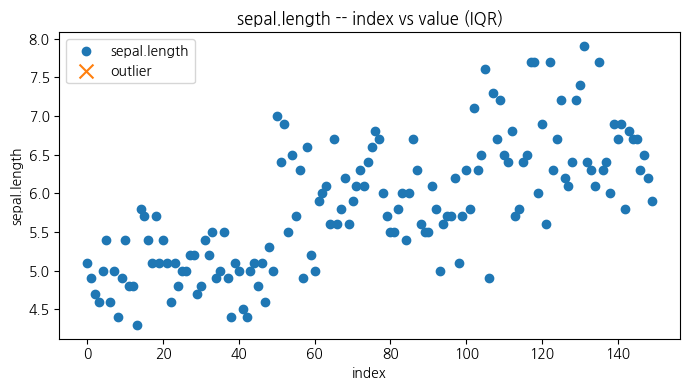

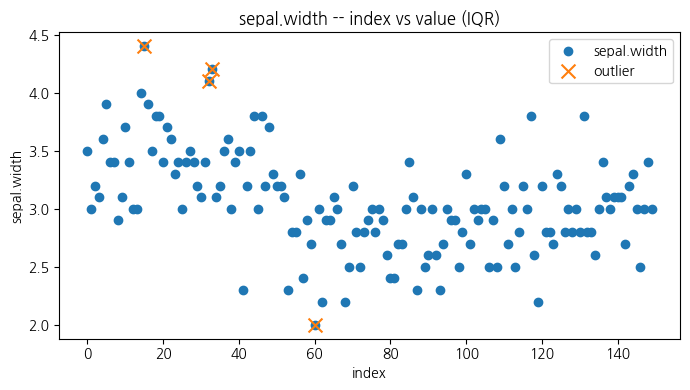

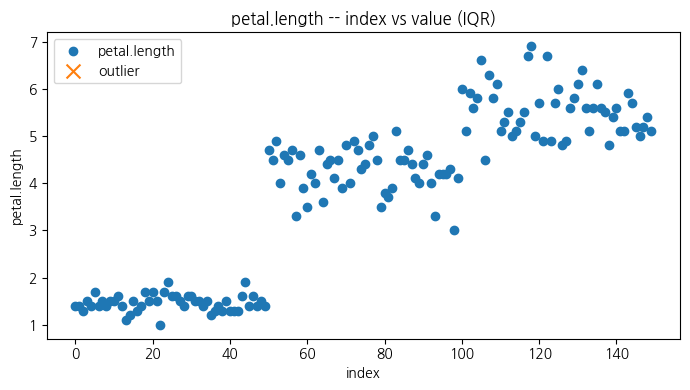

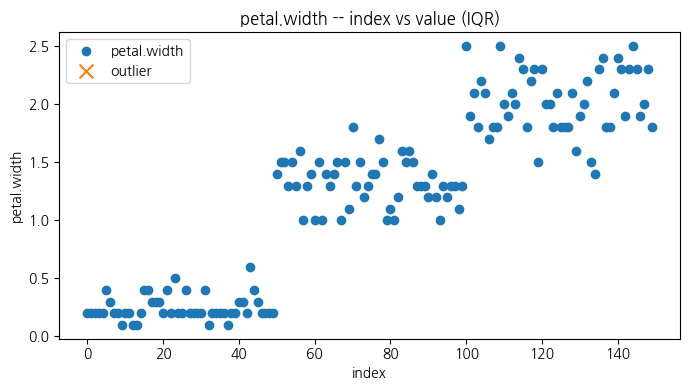

,columns,index,vlaue
0,sepal.width,15,NaN
1,sepal.width,32,NaN
2,sepal.width,33,NaN
3,sepal.width,60,NaN


In [34]:
## - 수치형 컬럼만 추출
## - select_dtype() : DF에 특정 타입의 컬럼 추출 반환
numeric_cols = irisDF.select_dtypes(include=['number']).columns.to_list()

## 컬럼별 이상치 & 일반 데이터 시각화
k = 1.5
visualize_outliers(irisDF, numeric_cols, k=k)

## 이상치 행만 추출 
outlier_records = get_outlier_records(irisDF, numeric_cols, k=k)
summary_df = pd.DataFrame(outlier_records, columns=['columns','index', 'vlaue'])
display(summary_df)

In [36]:
## 이상치를 버려야 하는 이유
## -----------------------------------------------------------------------------------------------------
## -- 입력 오류
## -- 측정 센서 오작동 일시적 오류로 비정상 수치
## -- 비정상 조건에서 수집된 데이터 
## -- 통계 모델(평균중심) 선형회귀, PCA 등 평균/분산 기반 모델은 이상치에 민감하므로 제거 유리
## -----------------------------------------------------------------------------------------------------

## -----------------------------------------------------------------------------------------------------
## 이상치를 유지해야 하는 이유
## -----------------------------------------------------------------------------------------------------
## -- 데이터 자체가 다양한 분포를 가짐 

## 실물 생물 데이터는 다양한 값 존재 가능. 이상치 치환
irisDF['sepal.width'] = cap_iqr(irisDF['sepal.width'])


In [43]:
## -----------------------------------------------------------------------------------------------------
## [2-6] 타겟 컬럼과 컬럼들의 상관관계성 검사
##      -> corr() 메서드
##      -> scatter 시각화
## -----------------------------------------------------------------------------------------------------
## 상관계수 
## -----------------------------------------------------------------------------------------------------

## replace() 경고
pd.set_option('future.no_silent_downcasting', True)

## 하드 코딩
irisDF.variety.replace({'Setosa':0, 'Versicolor' : 1, 'virginica' : 2})

## DF 복사본
irisDF2 = irisDF.copy()

## 고유값 리스트로 추출
vars = irisDF2.variety.unique().tolist()
irisDF2.variety = irisDF2.variety.replace(dict(zip(vars,range(len(vars)))))
display(irisDF2)

irisDF2.corr()
irisDF2.corr()['variety']

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


sepal.length    0.782561
sepal.width    -0.426572
petal.length    0.949035
petal.width     0.956547
variety         1.000000
Name: variety, dtype: float64

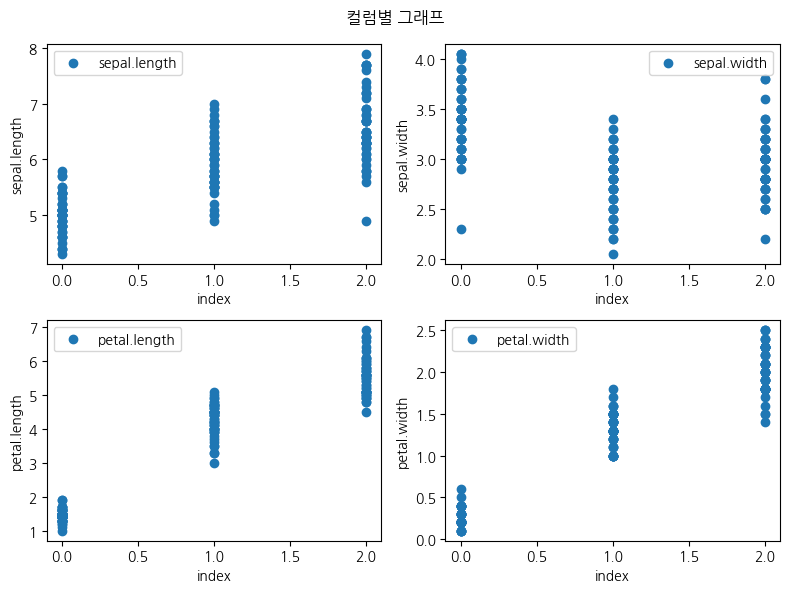

In [55]:
## 시각화 
plt.figure(figsize=(8, 6))
p_num = 1
for col in irisDF2.columns[:4] :
    plt.subplot(2,2,p_num)
    # plt.scatter(irisDF2.index, irisDF2[col], label=col)
    plt.scatter(irisDF2['variety'], irisDF2[col], label=col)
    # plt.xticks(['Setosa', 'Versicolor', 'virginica'],label=col)    
    plt.xlabel('index')
    plt.ylabel(col)
    plt.legend()
    p_num+=1

plt.suptitle("컬럼별 그래프")
plt.tight_layout()
plt.show()